# Train a diffusion model

Unconditional image generation is a popular application of diffusion models that generates images that look like those in the dataset used for training. Typically, the best results are obtained from finetuning a pretrained model on a specific dataset. You can find many of these checkpoints on the [Hub](https://huggingface.co/search/full-text?q=unconditional-image-generation&type=model), but if you can't find one you like, you can always train your own!

This tutorial will teach you how to train a [UNet2DModel](https://huggingface.co/docs/diffusers/main/en/api/models/unet2d#diffusers.UNet2DModel) from scratch on a subset of the [Smithsonian Butterflies](https://huggingface.co/datasets/huggan/smithsonian_butterflies_subset) dataset to generate your own 🦋 butterflies 🦋.

<Tip>

💡 This training tutorial is based on the [Training with 🧨 Diffusers](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/training_example.ipynb) notebook. For additional details and context about diffusion models like how they work, check out the notebook!

</Tip>

Before you begin, make sure you have 🤗 Datasets installed to load and preprocess image datasets, and 🤗 Accelerate, to simplify training on any number of GPUs. The following command will also install [TensorBoard](https://www.tensorflow.org/tensorboard) to visualize training metrics (you can also use [Weights & Biases](https://docs.wandb.ai/) to track your training).

In [2]:
# uncomment to install the necessary libraries in Colab
!pip install diffusers[training]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

We encourage you to share your model with the community, and in order to do that, you'll need to login to your Hugging Face account (create one [here](https://hf.co/join) if you don't already have one!). You can login from a notebook and enter your token when prompted:

In [1]:
from huggingface_hub import notebook_login

notebook_login()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Or login in from the terminal:

```bash
huggingface-cli login
```

Since the model checkpoints are quite large, install [Git-LFS](https://git-lfs.com/) to version these large files:

```bash
!sudo apt -qq install git-lfs
!git config --global credential.helper store
```

## Training configuration

For convenience, create a `TrainingConfig` class containing the training hyperparameters (feel free to adjust them):

In [2]:
from dataclasses import dataclass


@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "ddpm-butterflies-128"  # the model name locally and on the HF Hub

    push_to_hub = True  # whether to upload the saved model to the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0


config = TrainingConfig()

## Load the dataset

In [4]:
!pip install matplotlib-venn

You can easily load the [Smithsonian Butterflies](https://huggingface.co/datasets/huggan/smithsonian_butterflies_subset) dataset with the 🤗 Datasets library:

In [5]:
!apt-get -qq install -y libarchive-dev && pip install -U libarchive
import libarchive

Selecting previously unselected package libarchive-dev:amd64.
(Reading database ... 126213 files and directories currently installed.)
Preparing to unpack .../libarchive-dev_3.6.0-1ubuntu1.3_amd64.deb ...
Unpacking libarchive-dev:amd64 (3.6.0-1ubuntu1.3) ...
Setting up libarchive-dev:amd64 (3.6.0-1ubuntu1.3) ...
Processing triggers for man-db (2.10.2-1) ...
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 4.0 MB/s eta 0:00:00
  Created wheel for libarchive: filename=libarchive-0.4.7-py3-none-any.whl size=31629 sha256=593d246701716d6b7afaf05efed5c8356815856b32bd3b684d9d0491d0fd627f
  Stored in directory: /root/.cache/pip/wheels/32/98/bd/4893d6923dd027f455b250367d402bfd69a6f4416581df46db
Successfully built libarchive


In [6]:
!pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

In [7]:
from datasets import load_dataset

config.dataset_name = "huggan/smithsonian_butterflies_subset"
dataset = load_dataset(config.dataset_name, split="train")

README.md:   0%|          | 0.00/609 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


dataset_infos.json:   0%|          | 0.00/1.65k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/237M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

<Tip>

💡 You can find additional datasets from the [HugGan Community Event](https://huggingface.co/huggan) or you can use your own dataset by creating a local [`ImageFolder`](https://huggingface.co/docs/datasets/image_dataset#imagefolder). Set `config.dataset_name` to the repository id of the dataset if it is from the HugGan Community Event, or `imagefolder` if you're using your own images.

</Tip>

🤗 Datasets uses the [Image](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Image) feature to automatically decode the image data and load it as a [`PIL.Image`](https://pillow.readthedocs.io/en/stable/reference/Image.html) which we can visualize:

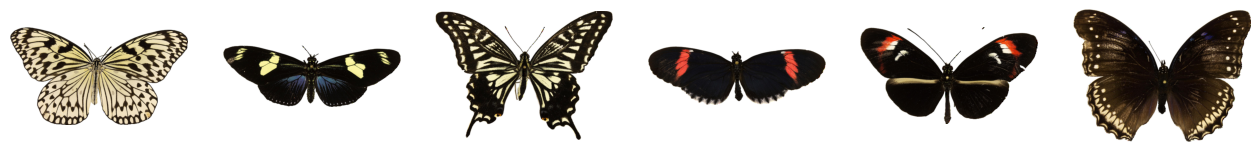

In [8]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 6, figsize=(16, 4))
for i, image in enumerate(dataset[:6]["image"]):
    axs[i].imshow(image)

    axs[i].set_axis_off()
fig.show()

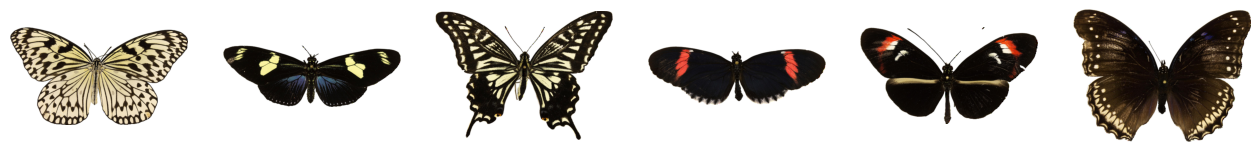

In [9]:
from torchvision import transforms  #necessary for

preprocess = transforms.Compose(  #combines multiple image transformations into a single pipeline that will be applied sequentially to input images.
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(), #traditional data aug technique randomly flips the image horizontally with a 50% probability.
        transforms.ToTensor(), #converts the image from a PIL Image or numpy array to a PyTorch tensor (and scales pixel values from [0,255] to [0,1])
        transforms.Normalize([0.5], [0.5]), #normalization : mean 0.5 and standard deviation 0.5 if rgb then Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]
)

#Modifications needed :
If using a pretrained model, you’d use the normalization stats it was trained with (e.g., ImageNet uses mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.224]).

For more augmentation, you could add RandomRotation, ColorJitter, etc.

Use 🤗 Datasets' [set_transform](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.set_transform) method to apply the `preprocess` function on the fly during training:

In [10]:
def transform(examples): # this function converts all images in examples to RGB
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images} #dictionnary
dataset.set_transform(transform)

Feel free to visualize the images again to confirm that they've been resized. Now you're ready to wrap the dataset in a [DataLoader](https://pytorch.org/docs/stable/data#torch.utils.data.DataLoader) for training!

In [11]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def denormalize(tensor, mean=0.5, std=0.5):
    """Reverses Normalize(mean, std)."""
    tensor = tensor.clone()  # Avoid modifying original tensor
    tensor = (tensor * std) + mean  # Reverse: (x - mean)/std → x*std + mean
    tensor = torch.clamp(tensor, 0, 1)  # Clamp to [0, 1] to avoid artifacts
    return tensor



In [12]:
def show_transformed_images(dataset, num_images=8):
    # Get a batch of transformed images
    batch = [dataset[i]["images"] for i in range(num_images)]  # If using HuggingFace datasets
    batch = torch.stack(batch)  # Stack into a single tensor (N, C, H, W)

    # Denormalize and convert to numpy (HWC format)
    batch = denormalize(batch)
    grid = make_grid(batch, nrow=4)  # Arrange in a grid

    # Display
    plt.figure(figsize=(12, 8))
    plt.imshow(grid.permute(1, 2, 0))  # CHW → HWC for matplotlib yess
    plt.axis("off")
    plt.show()

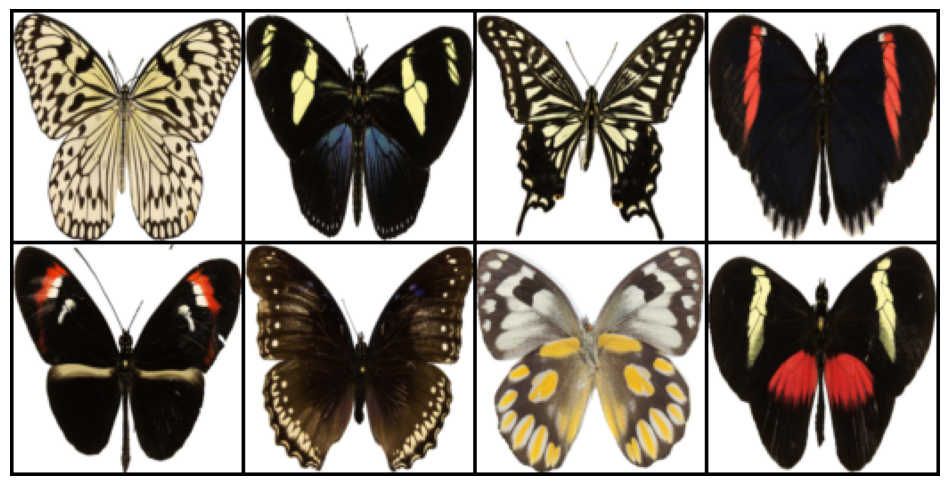

In [13]:
show_transformed_images(dataset, num_images=8)

In [14]:
import torch
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)  #

## Create a UNet2DModel

Pretrained models in 🧨 Diffusers are easily created from their model class with the parameters you want. For example, to create a [UNet2DModel](https://huggingface.co/docs/diffusers/main/en/api/models/unet2d#diffusers.UNet2DModel):

In [15]:
from diffusers import UNet2DModel

model = UNet2DModel(
    #images configs and settings
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels

    #Model Architecture
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

It is often a good idea to quickly check the sample image shape matches the model output shape:

In [16]:
sample_image = dataset[0]["images"].unsqueeze(0)
print("Input shape:", sample_image.shape)

Input shape: torch.Size([1, 3, 128, 128])


In [17]:
print("Output shape:", model(sample_image, timestep=0).sample.shape)

Output shape: torch.Size([1, 3, 128, 128])


Great! Next, you'll need a scheduler to add some noise to the image.

## Create a scheduler

The scheduler behaves differently depending on whether you're using the model for training or inference. During inference, the scheduler generates image from the noise. During training, the scheduler takes a model output - or a sample - from a specific point in the diffusion process and applies noise to the image according to a *noise schedule* and an *update rule*.

Let's take a look at the [DDPMScheduler](https://huggingface.co/docs/diffusers/main/en/api/schedulers/ddpm#diffusers.DDPMScheduler) and use the `add_noise` method to add some random noise to the `sample_image` from before:

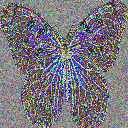

In [18]:
import torch
from PIL import Image
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 200.0).type(torch.uint8).numpy()[0])

127.5
<div class="flex justify-center">
    <img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/noisy_butterfly.png"/>
</div>
128.5

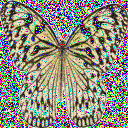

200

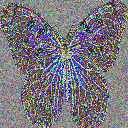

The training objective of the model is to predict the noise added to the image. The loss at this step can be calculated by:

mage.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

In [21]:
import torch.nn.functional as F

noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)
print(loss)

tensor(1.0520, grad_fn=<MseLossBackward0>)


## Train the model

By now, you have most of the pieces to start training the model and all that's left is putting everything together.

First, you'll need an optimizer and a learning rate scheduler:

In [22]:
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

Then, you'll need a way to evaluate the model. For evaluation, you can use the [DDPMPipeline](https://huggingface.co/docs/diffusers/main/en/api/pipelines/ddpm#diffusers.DDPMPipeline) to generate a batch of sample images and save it as a grid:

In [23]:
from diffusers import DDPMPipeline
import math
import os


def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i % cols * w, i // cols * h))
    return grid


def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
    ).images

    # Make a grid out of the images
    image_grid = make_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

Now you can wrap all these components together in a training loop with 🤗 Accelerate for easy TensorBoard logging, gradient accumulation, and mixed precision training. To upload the model to the Hub, write a function to get your repository name and information and then push it to the Hub.

<Tip>

💡 The training loop below may look intimidating and long, but it'll be worth it later when you launch your training in just one line of code! If you can't wait and want to start generating images, feel free to copy and run the code below. You can always come back and examine the training loop more closely later, like when you're waiting for your model to finish training. 🤗

</Tip>

In [24]:
from google.colab import drive
drive.mount('/content/drive')

# Navigate to your folder
repo_path = "/content/drive/MyDrive/RepoButterflies"  # Adjust path as needed

Mounted at /content/drive


In [29]:
from accelerate import Accelerator
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
import os

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        if config.push_to_hub:
            repo_id = create_repo(
                repo_id="DMtraining", exist_ok=True
                ).repo_id

        accelerator.init_trackers("train_example")

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch["images"]
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape, device=clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device,
                dtype=torch.int64
            )

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    upload_folder(
                        repo_id=repo_id,
                        folder_path=config.output_dir,
                        commit_message=f"Epoch {epoch}",
                        ignore_patterns=["step_*", "epoch_*"],
                    )
                else:
                    pipeline.save_pretrained(config.output_dir)

Phew, that was quite a bit of code! But you're finally ready to launch the training with 🤗 Accelerate's [notebook_launcher](https://huggingface.co/docs/accelerate/main/en/package_reference/launchers#accelerate.notebook_launcher) function. Pass the function the training loop, all the training arguments, and the number of processes (you can change this value to the number of GPUs available to you) to use for training:

In [26]:
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device count: {torch.cuda.device_count()}")
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"CUDA device name: {torch.cuda.get_device_name(0)}")


CUDA available: True
CUDA device count: 1
Current CUDA device: 0
CUDA device name: Tesla T4


In [27]:
# Instead of using notebook_launcher:

train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

AttributeError: 'TrainingConfig' object has no attribute 'hub_model_id'

In [ ]:
from accelerate import notebook_launcher

args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)


Launching training on one GPU.


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

events.out.tfevents.1744033791.16bc96dca0a9.375.0:   0%|          | 0.00/240k [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

0009.png:   0%|          | 0.00/544k [00:00<?, ?B/s]

0019.png:   0%|          | 0.00/519k [00:00<?, ?B/s]

0029.png:   0%|          | 0.00/504k [00:00<?, ?B/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Once training is complete, take a look at the final 🦋 images 🦋 generated by your diffusion model!

In [ ]:
import glob

sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])


Generated images noise 127.5

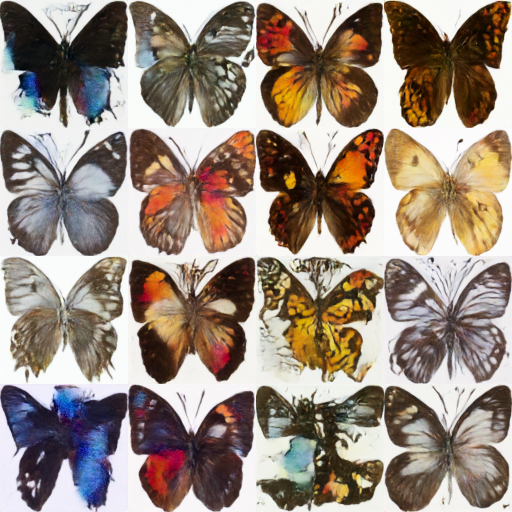

<div class="flex justify-center">
    <img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/butterflies_final.png"/>
</div>

## Next steps

Unconditional image generation is one example of a task that can be trained. You can explore other tasks and training techniques by visiting the [🧨 Diffusers Training Examples](https://huggingface.co/docs/diffusers/main/en/tutorials/../training/overview) page. Here are some examples of what you can learn:

* [Textual Inversion](https://huggingface.co/docs/diffusers/main/en/tutorials/../training/text_inversion), an algorithm that teaches a model a specific visual concept and integrates it into the generated image.
* [DreamBooth](https://huggingface.co/docs/diffusers/main/en/tutorials/../training/dreambooth), a technique for generating personalized images of a subject given several input images of the subject.
* [Guide](https://huggingface.co/docs/diffusers/main/en/tutorials/../training/text2image) to finetuning a Stable Diffusion model on your own dataset.
* [Guide](https://huggingface.co/docs/diffusers/main/en/tutorials/../training/lora) to using LoRA, a memory-efficient technique for finetuning really large models faster.